In [16]:
#import necessary libraries

import glob
from PIL import Image
from PIL.ExifTags import TAGS, GPSTAGS
import pandas as pd
import os
import math

from sentinelhub import SentinelHubRequest, DataCollection, MimeType, CRS, BBox, SHConfig, bbox_to_dimensions
import datetime
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from geopy.distance import geodesic
from PIL import Image as PILImage

In [17]:
#replace with path to the project folder
current_dir = 'e:\\BOSTON UNIVERSITY\\CAS CS 549\\ml-terc-image-geolocation'  
os.chdir(current_dir)

In [18]:
def get_exif_data(image_path):
    """
    Function to extract specific EXIF metadata - GPS coordinates, 
    camera model, and focal length from an image file. 
    --------------------------------------------------------------
    Parameters:
    image_path: A string representing the file path of the image from which the EXIF data is to be extracted.
    --------------------------------------------------------------
    Returns:
    A tuple of lists containing the EXIF tags and their corresponding values.
    """
    desired_tags = ['GPSLatitudeRef', 'GPSLatitude', 'GPSLongitudeRef', 
                    'GPSLongitude', 'GPSAltitude', 'Model', 'FocalLength', "DateTime"]

    image = Image.open(image_path)
    exif_data = image._getexif()
    exif_dict = {}

    if exif_data is not None:
        for key, value in exif_data.items():
            if key in TAGS:
                tag = TAGS[key]

                if tag == 'GPSInfo':
                    gps_data = {}
                    for t in value:
                        sub_tag = GPSTAGS.get(t, t)
                        if sub_tag in desired_tags:
                            gps_data[sub_tag] = value[t]
                    exif_dict.update(gps_data)
                elif tag in desired_tags:
                    exif_dict[tag] = value

    return exif_dict



In [19]:
def get_geo_coord(lat, ref_lat, lon, ref_lon):
    """
    Function to convert EXIF GPS coordinates to decimal format.
    --------------------------------------------------------------
    Parameters:
    lat: A list of tuples containing the GPS latitude coordinates in degrees, minutes, and seconds.
    ref_lat: A string representing the reference direction(N, S) of the GPS latitude coordinates.
    lon: A list of tuples containing the GPS longitude coordinates in degrees, minutes, and seconds.
    ref_lon: A string representing the reference direction(E, W) of the GPS longitude coordinates.
    --------------------------------------------------------------
    Returns:
    A tuple of floats representing the GPS coordinates in decimal format.
    """
    deg, minutes, seconds = lat
    decimal_deg_lat = deg + (minutes / 60.0) + (seconds / 3600.0)

    # Adjusting for the reference direction
    if ref_lat == 'S':
        decimal_deg_lat *= -1

    deg, minutes, seconds = lon
    decimal_deg_lon = deg + (minutes / 60.0) + (seconds / 3600.0)

    # Adjusting for the reference direction
    if ref_lon == 'W':
        decimal_deg_lon *= -1

    return decimal_deg_lat, decimal_deg_lon

In [28]:
def fetch_sentinel_image(lat, lon, start_date, end_date, instance_id, sh_client_id, sh_client_secret, km_range=300):
    """
    Fetches a Sentinel satellite image for a given location, date, and range.
    --------------------------------------------------------------
    Parameters:
    lat (float): Latitude of the center point.
    lon (float): Longitude of the center point.
    date (str): Date of the desired imagery in 'YYYY-MM-DD' format.
    instance_id (str): Sentinel Hub instance ID.
    sh_client_id (str): Sentinel Hub client ID.
    sh_client_secret (str): Sentinel Hub client secret.
    km_range (int): The range in kilometers for the area around the center point (default 300km).
    --------------------------------------------------------------
    Returns:
    A matplotlib image plot.
    """
    config = SHConfig()
    config.instance_id = instance_id
    config.sh_client_id = sh_client_id
    config.sh_client_secret = sh_client_secret

    # Calculate the bounding box (approximation)
    # Sentinel Hub uses WGS84 coordinate system which is in degrees
    # Approximation: 1 degree latitude = 111 km
    # This is a rough approximation and varies with location
    delta_degree = (km_range / 2) / 111  # Convert km to degrees
    bbox_coords = [lon - delta_degree, lat - delta_degree, lon + delta_degree, lat + delta_degree]
    bbox = BBox(bbox_coords, crs=CRS.WGS84)
    resolution = 10  # Resolution in meters

    # Calculate size
    size_x, size_y = bbox_to_dimensions(bbox, resolution=resolution)

    # Ensure the size does not exceed the maximum allowed by Sentinel Hub
    max_size = 2500
    size = (min(size_x, max_size), min(size_y, max_size))


    # Define an evalscript: a JavaScript program that tells the service how to process the data
    evalscript = """
        //VERSION=3
        function setup() {
            return {
                input: ["B02", "B03", "B04"],
                output: { bands: 3 }
            };
        }

        function evaluatePixel(sample) {
            return [sample.B04, sample.B03, sample.B02];
        }
    """

    # Define the request
    request = SentinelHubRequest(
        evalscript=evalscript,
        input_data=[
            SentinelHubRequest.input_data(
                data_collection=DataCollection.SENTINEL2_L1C,
                time_interval=(start_date, end_date),
                mosaicking_order='mostRecent'
            )
        ],
        responses=[
            SentinelHubRequest.output_response('default', MimeType.PNG)
        ],
        bbox=bbox,
        size=size,
        config=config
    )
    
    # Fetch the image
    image_array = request.get_data()[0]  # This will be a NumPy array

    # Convert the NumPy array to a PIL Image
    image = PILImage.fromarray(image_array)

    # Plot the image
    plt.imshow(image)
    plt.axis('off')
    plt.show()

In [29]:
#use exif image to get metadata of interest from the image

query_img_path = "data\\images\\iss050e070478.jpg"

exif_data = get_exif_data(query_img_path)

print(f"Extracted Metadata:\n {exif_data}")

Extracted Metadata:
 {'GPSLatitudeRef': 'N', 'GPSLatitude': (42.0, 10.3992, 0.0), 'GPSLongitudeRef': 'W', 'GPSLongitude': (74.0, 36.3344, 0.0), 'GPSAltitude': 404564.54545454547, 'Model': 'NIKON D4', 'DateTime': '2017:10:16 09:38:48', 'FocalLength': 1150.0}


In [30]:
# Extracting GPS data for conversion
gps_latitude = exif_data.get('GPSLatitude', None)
gps_latitude_ref = exif_data.get('GPSLatitudeRef', None)
gps_longitude = exif_data.get('GPSLongitude', None)
gps_longitude_ref = exif_data.get('GPSLongitudeRef', None)

# Check if all GPS data is available
if gps_latitude and gps_latitude_ref and gps_longitude and gps_longitude_ref:
    lat, long = get_geo_coord(gps_latitude, gps_latitude_ref, gps_longitude, gps_longitude_ref)
    print(f"Center coordinates: {lat}, {long}")
else:
    print("GPS data is incomplete or not available in the image.")

Center coordinates: 42.17332, -74.60557333333334


In [44]:
def fetch_sentinel_image(lat, lon, start_date, end_date, instance_id, sh_client_id, sh_client_secret, km_range=300):
    """
    Fetches a Sentinel satellite image for a given location, date range, and size.
    """
    # Configure Sentinel Hub connection
    config = SHConfig()
    config.instance_id = instance_id
    config.sh_client_id = sh_client_id
    config.sh_client_secret = sh_client_secret

    # Calculate the bounding box (approximation)
    delta_degree = (km_range / 2) / 111  # Convert km to degrees
    bbox_coords = [lon - delta_degree, lat - delta_degree, lon + delta_degree, lat + delta_degree]
    bbox = BBox(bbox_coords, crs=CRS.WGS84)

    size = (2500, 2500)

    # Define an evalscript
    evalscript = """
        //VERSION=3
        function setup() {
            return {
                input: ["B02", "B03", "B04"],
                output: { bands: 3 }
            };
        }

        function evaluatePixel(sample) {
            return [sample.B04, sample.B03, sample.B02];
        }
    """

    # Define the request
    request = SentinelHubRequest(
        evalscript=evalscript,
        input_data=[
            SentinelHubRequest.input_data(
                data_collection=DataCollection.SENTINEL2_L1C,
                time_interval=(start_date, end_date),
                mosaicking_order='mostRecent'
            )
        ],
        responses=[
            SentinelHubRequest.output_response('default', MimeType.PNG)
        ],
        bbox=bbox,
        size=size,
        config=config
    )

    # Fetch the image
    image_array = request.get_data()[0]  # This will be a NumPy array

    # Convert the NumPy array to a PIL Image
    image = PILImage.fromarray(image_array)

    # Save the image to a file
    image.save('sentinel_image.png')

    # Plot the image
    plt.imshow(image)
    plt.axis('off')
    plt.show()


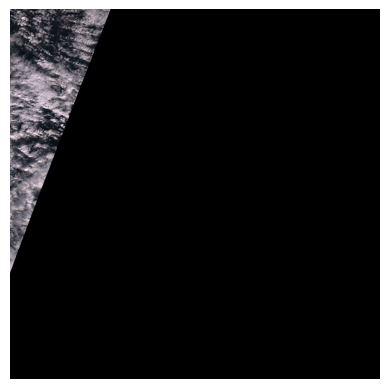

In [45]:
# Generate Area of interest

#replace with own id and secret
instance_id = "bf7d62ab-112e-4ff3-a019-6a1367f3da71"
sh_client_id = "0fccb902-d212-466e-9ae7-9c5e09188fb3"
sh_client_secret ="EJ4iUK0RWrinankG6RvkFMcI8SkKTWkpRvs2vbAK"


parsed_datetime = datetime.strptime(exif_data['DateTime'], '%Y:%m:%d %H:%M:%S')
start_date = parsed_datetime.strftime('%Y-%m-%d')
end_date = (parsed_datetime + timedelta(days=1)).strftime('%Y-%m-%d')


fetch_sentinel_image(lat, long, start_date, end_date, instance_id, sh_client_id, sh_client_secret)

In [9]:
# Define sensor sizes for different camera models
sensor_sizes = {
    'NIKON D2Xs': (23.6, 15.8),  # APS-C sensor size in mm
    'NIKON D3S': (36, 24),       # Full-frame sensor size in mm
    'NIKON D3X': (36, 24),       # Full-frame sensor size in mm
    'NIKON D4': (36, 24),        # Full-frame sensor size in mm
    'NIKON D5': (36, 24),        # Full-frame sensor size in mm
    'NIKON D850': (35.9, 23.9)   # Full-frame sensor size in mm
}